In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
def logic_win(x,x_r):
    return (x >= x_r[0]) & (x < x_r[1])

def make_bins(xlim,dx):
    Edges_x = np.arange(xlim[0],xlim[1]+dx,dx)
    Bins_x = Edges_x[:-1]+dx/2
    return Edges_x,Bins_x

def ind_match(x,A):
    return np.argwhere(A == x)[:,0][0]

def r_category(x):
    return x[0]

In [3]:
path = '../DataFrames/df_road_v3_zeros.csv'
df_road = pd.read_csv(path)

In [4]:
Ys = 2005 #must start before or on this year
Ye = 2018 #must end this year or later

Igap = df_road.Max_year_gap == 1 #we don't want gaps
Istart = df_road.Year_start <= Ys
Iend = df_road.Year_end >= Ye
Iyears = Igap & Istart & Iend

df_road_sub = df_road.loc[Iyears,:].copy()

In [5]:
f_include = ['ID', 'total', 'slight', 'serious',
       'bikelane','aadf_Road_name', 'aadf_Road_category', 'aadf_Road_type',
       'aadf_CLT_CARR', 'aadf_CLT_SEGREG', 'aadf_CLT_STEPP', 'aadf_CLT_PARSEG',
       'aadf_CLT_SHARED', 'aadf_CLT_MANDAT', 'aadf_CLT_ADVIS',
       'aadf_CLT_PRIORI', 'aadf_CLT_CONTRA', 'aadf_CLT_BIDIRE',
       'aadf_CLT_CBYPAS', 'aadf_CLT_BBYPAS', 'aadf_CLT_PARKR',
       'aadf_CLT_WATERR', 'aadf_CLT_PTIME', 'aadf_Link_length_miles',
       'aadf_Pedal_cycles', 'aadf_All_motor_vehicles',
       'aadf_All_HGVs', 'aadf_LGVs', 'aadf_Buses_and_coaches', 'total_dnorm',
       'total_dnorm_bvnorm', 'serious_ratio']

df_cluster = df_road_sub[f_include].copy()

#make a sample length scaled total normalized to aadf_Link_length instead
LL_med = df_cluster.aadf_Link_length_miles.median()
df_cluster['total_dnorm_LL'] = df_cluster.total.values*LL_med/df_cluster.aadf_Link_length_miles.values

In [6]:
f_scale = ['aadf_Pedal_cycles', 'aadf_All_motor_vehicles',
       'aadf_All_HGVs', 'aadf_LGVs', 'aadf_Buses_and_coaches']

for f in f_scale:
    fname = f+'_s'
    mean = df_cluster[f].mean()
    std = df_cluster[f].std()
    #df_cluster.loc[:,f] = (df_cluster[f].values - mean)/std
    df_cluster[fname] = (df_cluster[f].values - mean)/std

In [7]:
#pick which features to try clustering on
f_cluster = ['bikelane','aadf_Pedal_cycles_s', 'aadf_All_motor_vehicles_s', 'aadf_All_HGVs_s',
       'aadf_LGVs_s', 'aadf_Buses_and_coaches_s']

In [11]:
f_raw = ['aadf_Link_length_miles',
       'aadf_Pedal_cycles', 'aadf_All_motor_vehicles',
       'aadf_All_HGVs', 'aadf_LGVs', 'aadf_Buses_and_coaches', 'total_dnorm',
       'total_dnorm_bvnorm']
f_bool = ['bikelane','aadf_CLT_CARR', 'aadf_CLT_SEGREG', 'aadf_CLT_STEPP', 'aadf_CLT_PARSEG',
       'aadf_CLT_SHARED', 'aadf_CLT_MANDAT', 'aadf_CLT_ADVIS',
       'aadf_CLT_PRIORI', 'aadf_CLT_CONTRA', 'aadf_CLT_BIDIRE',
       'aadf_CLT_CBYPAS', 'aadf_CLT_BBYPAS', 'aadf_CLT_PARKR',
       'aadf_CLT_WATERR', 'aadf_CLT_PTIME']
f_one_hot = ['aadf_Road_type', 'aadf_Road_category']

In [12]:
df_cluster.loc[:, df_cluster.dtypes.eq('bool')] = df_cluster.loc[:, df_cluster.dtypes.eq('bool')].astype(np.int8)

In [13]:
df_cluster = df_cluster.drop(df_cluster.index[[i[0] for i in np.argwhere(np.isinf(df_cluster[f_raw].values)[:,7])]])

In [14]:
KM = KMeans(3)

KM.fit(df_cluster[f_cluster])
cluster_centers = KM.cluster_centers_

inertias = KM.inertia_

clusters = KM.predict(df_cluster[f_cluster])

In [15]:
df_cluster['aadf_Road_type'] = df_cluster.aadf_Road_name.apply(r_category)

In [16]:
scaler = StandardScaler()

df_FADM = pd.DataFrame(data=scaler.fit_transform(df_cluster[f_raw]),
                       index = df_cluster.index,
                      columns = f_raw)

In [34]:
df_FADM[f_bool] = df_cluster[f_bool]

bool_scaled = df_FADM[f_bool] / np.sqrt((df_FADM[f_bool] == 1).astype(int).sum(axis=0).values)
df_FADM[f_bool] = bool_scaled - bool_scaled.mean()

In [18]:
jobs_encoder = OneHotEncoder()
transformed = jobs_encoder.fit_transform(df_cluster[f_one_hot])
#get OHE columns
f_one_hot_t = jobs_encoder.get_feature_names_out().tolist()
#concat with original data
df_FADM[jobs_encoder.get_feature_names_out()] = transformed.toarray()

In [19]:
fohet_scaled = df_FADM[f_one_hot_t] / np.sqrt((df_FADM[f_one_hot_t] == 1).astype(int).sum(axis=0).values)
df_FADM[jobs_encoder.get_feature_names_out()] = fohet_scaled - fohet_scaled.mean()

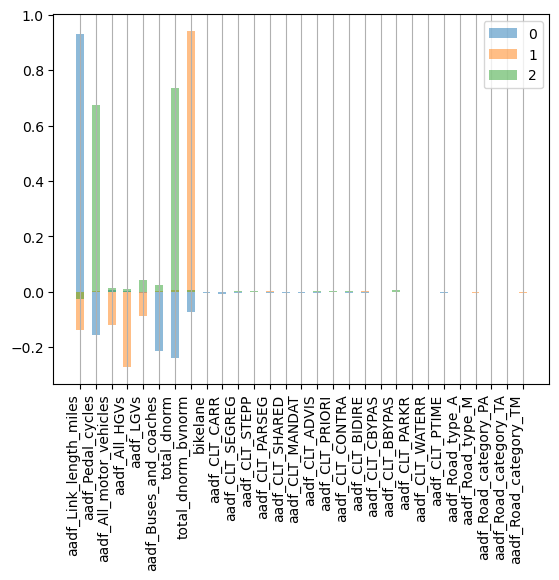

In [36]:
fig, (ax0) = plt.subplots(1,sharex=True)

for i in range(3):
    pca = PCA(1)

    pca.fit(df_FADM[clusters==i])

    pca.components_.shape
    
    ax0.bar(f_raw+f_bool+f_one_hot_t,pca.components_[0],label=i,width=-0.5,y=0,alpha=0.5)
    plt.xticks(rotation=90, ha='right');
    plt.grid(axis='x')
    
plt.legend()

In [37]:
df_FADM.head()

,aadf_Link_length_miles,aadf_Pedal_cycles,aadf_All_motor_vehicles,aadf_All_HGVs,aadf_LGVs,aadf_Buses_and_coaches,total_dnorm,total_dnorm_bvnorm,bikelane,aadf_CLT_CARR,...,aadf_CLT_CBYPAS,aadf_CLT_BBYPAS,aadf_CLT_PARKR,aadf_CLT_WATERR,aadf_CLT_PTIME,aadf_Road_type_A,aadf_Road_type_M,aadf_Road_category_PA,aadf_Road_category_TA,aadf_Road_category_TM
0,0.276489,1.739646,0.471766,0.011420,0.452189,0.998726,3.828942,-0.003285,0.010525,0.014572,...,-0.00248,0.174077,-0.006562,-0.0027,-0.010684,0.000699,-0.003878,0.001036,-0.002614,-0.003907
1,-0.122318,0.592163,-0.258505,-0.151249,-0.246186,0.345267,4.722438,0.438846,0.010525,0.014572,...,-0.00248,-0.002700,-0.006562,-0.0027,0.033993,0.000699,-0.003878,0.001036,-0.002614,-0.003907
2,0.353677,2.852179,-0.225521,-0.188490,0.068802,0.738189,3.987003,-0.101223,0.010525,0.014572,...,-0.00248,-0.002700,-0.006562,-0.0027,-0.010684,0.000699,-0.003878,0.001036,-0.002614,-0.003907
3,0.353677,1.974315,-0.137112,-0.081489,-0.056907,0.291546,2.881671,-0.096625,0.010525,0.014572,...,-0.00248,0.174077,-0.006562,-0.0027,0.033993,0.000699,-0.003878,0.001036,-0.002614,-0.003907
4,0.752484,1.776737,-0.424164,-0.266242,-0.377088,3.041733,2.979901,-0.069964,0.010525,0.014572,...,-0.00248,-0.002700,-0.006562,-0.0027,0.033993,0.000699,-0.003878,0.001036,-0.002614,-0.003907


In [80]:
pca = PCA(2)

fit = pca.fit_transform(df_FADM)

In [82]:
fit.shape

(2095, 2)

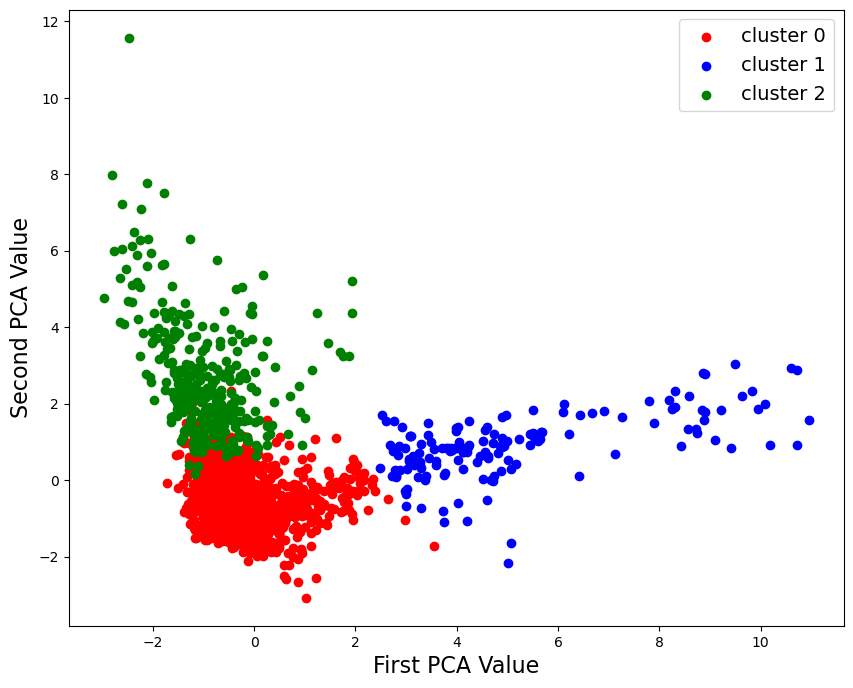

In [38]:
pca = PCA(2)

fit = pca.fit_transform(df_FADM)

plt.figure(figsize=(10,8))

plt.scatter(fit[clusters == 0, 0], 
            fit[clusters == 0, 1],
            color = 'r',
            label="cluster 0")

plt.scatter(fit[clusters == 1, 0], 
            fit[clusters == 1, 1],
            color = 'b',
            label="cluster 1")

plt.scatter(fit[clusters == 2, 0], 
            fit[clusters == 2, 1],
            color = 'g',
            label="cluster 2")

plt.legend(fontsize=14)

plt.xlabel("First PCA Value", fontsize=16)
plt.ylabel("Second PCA Value", fontsize=16)

plt.show()

In [41]:
np.argwhere(clusters==i)

(1606, 1)

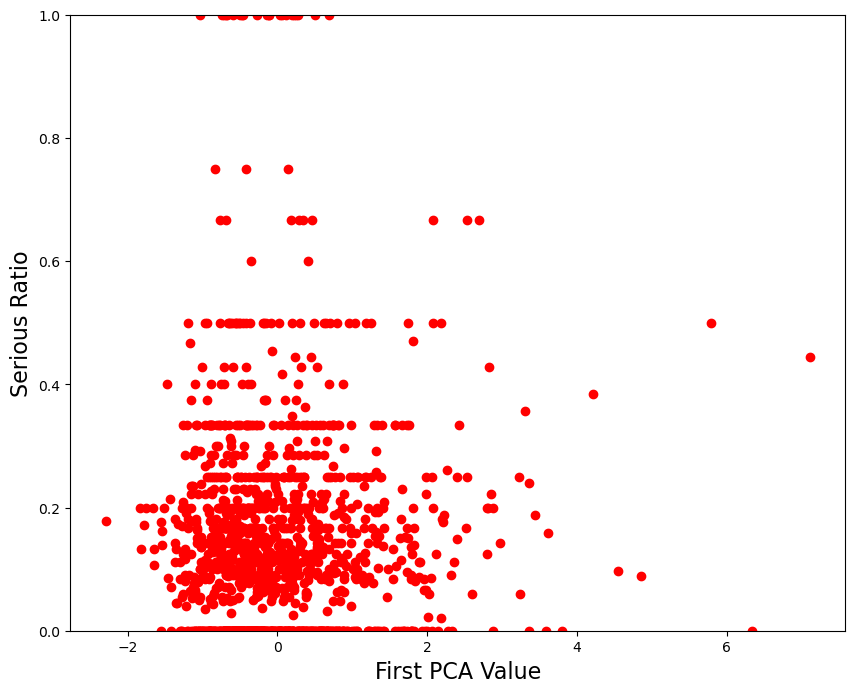

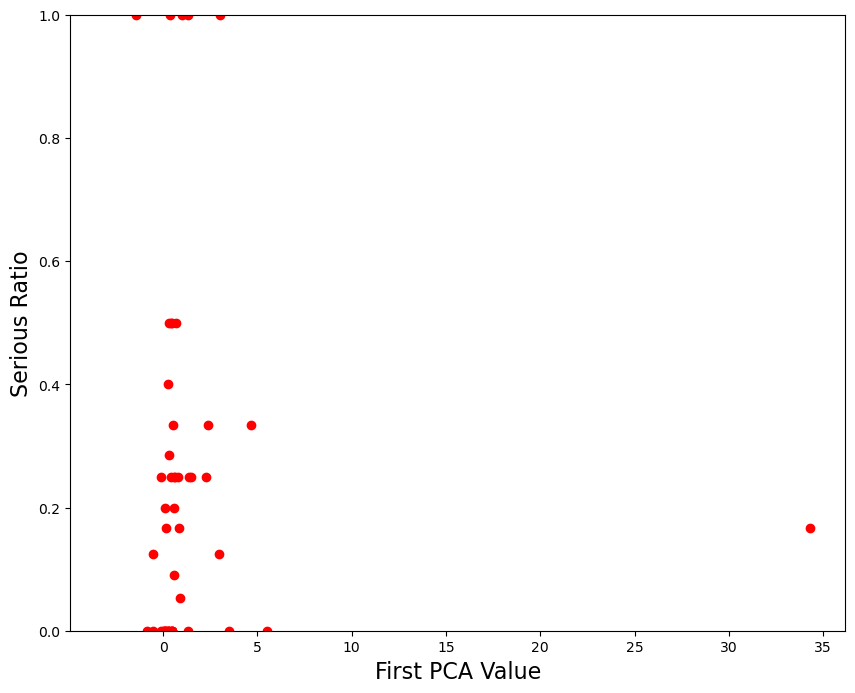

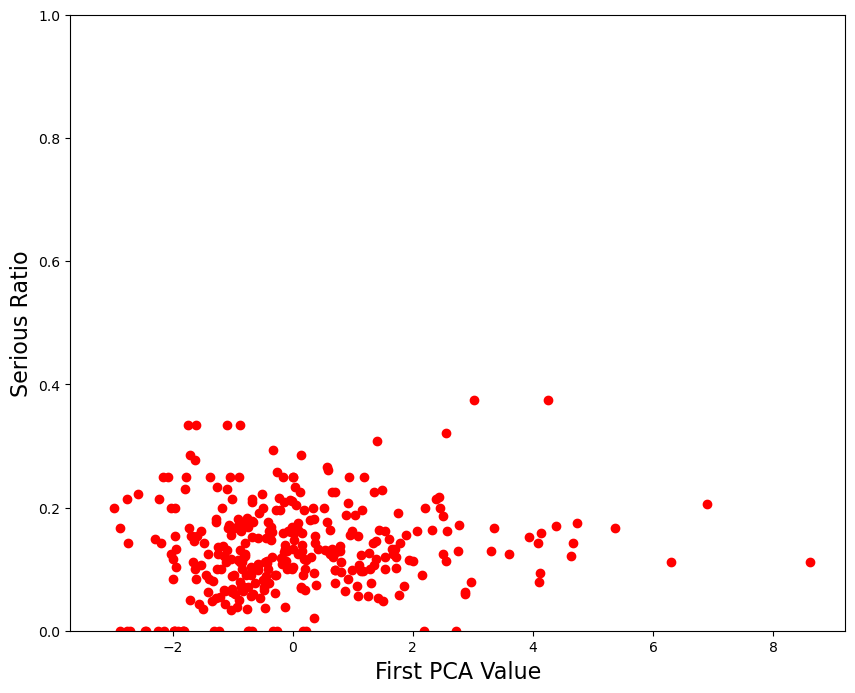

In [46]:
for i in range(3):

    pca = PCA(1)

    fit = pca.fit_transform(df_FADM[clusters == i])

    plt.figure(figsize=(10,8))

    plt.scatter(fit, 
                df_cluster[clusters == i].serious_ratio,
                color = 'r',
                label="cluster 0")

    plt.xlabel("First PCA Value", fontsize=16)
    plt.ylabel("Serious Ratio", fontsize=16)
    plt.ylim([0,1])

In [49]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [77]:
df_train

,aadf_Link_length_miles,aadf_Pedal_cycles,aadf_All_motor_vehicles,aadf_All_HGVs,aadf_LGVs,aadf_Buses_and_coaches,total_dnorm,total_dnorm_bvnorm,bikelane,aadf_CLT_CARR,...,aadf_CLT_CBYPAS,aadf_CLT_BBYPAS,aadf_CLT_PARKR,aadf_CLT_WATERR,aadf_CLT_PTIME,aadf_Road_type_A,aadf_Road_type_M,aadf_Road_category_PA,aadf_Road_category_TA,aadf_Road_category_TM
1619,-0.521125,-0.559217,0.019671,0.407942,-0.194439,-0.662621,-0.541216,0.006022,-0.017210,-0.015745,...,-0.00248,-0.0027,-0.006562,-0.0027,-0.010684,0.000699,-0.003878,0.001036,-0.002614,-0.003907
1573,-0.521125,-0.548584,-0.068290,-0.284490,-0.252822,-0.737883,-0.574165,-0.136422,-0.017210,-0.015745,...,-0.00248,-0.0027,-0.006562,-0.0027,-0.010684,0.000699,-0.003878,0.001036,-0.002614,-0.003907
1888,0.044924,-0.568560,-0.105550,0.382436,0.111731,-0.410021,-0.642182,-0.309503,0.010525,-0.015745,...,-0.00248,-0.0027,-0.006562,-0.0027,-0.010684,0.000699,-0.003878,0.001036,-0.002614,-0.003907
1220,-0.521125,-0.534730,-0.308436,-0.378543,-0.519404,-0.502688,-0.464033,0.070076,0.010525,0.014572,...,-0.00248,-0.0027,-0.006562,-0.0027,-0.010684,0.000699,-0.003878,0.001036,-0.002614,-0.003907
1515,0.199300,-0.591517,1.410017,0.497214,0.847874,0.164326,-0.536878,0.526819,-0.017210,-0.015745,...,-0.00248,-0.0027,-0.006562,-0.0027,-0.010684,0.000699,-0.003878,0.001036,-0.002614,-0.003907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1507,-0.598314,-0.467069,-0.332548,-0.110041,-0.183475,-0.618521,-0.414576,-0.057218,-0.017210,-0.015745,...,-0.00248,-0.0027,-0.006562,-0.0027,-0.010684,0.000699,-0.003878,0.001036,-0.002614,-0.003907
2156,-0.675502,0.269815,-0.075905,-0.065152,0.007930,0.122092,-0.648351,-0.333044,0.010525,0.014572,...,-0.00248,-0.0027,-0.006562,-0.0027,0.033993,0.000699,-0.003878,0.001036,-0.002614,-0.003907
1456,0.122112,-0.447495,-0.268535,-0.334053,-0.249258,-0.154246,-0.508984,-0.187939,-0.017210,-0.015745,...,-0.00248,-0.0027,-0.006562,-0.0027,-0.010684,0.000699,-0.003878,0.001036,-0.002614,-0.003907
1534,2.682196,-0.543429,-0.585482,-0.478539,-0.623821,-0.725182,-0.594506,-0.200759,-0.017210,-0.015745,...,-0.00248,-0.0027,-0.006562,-0.0027,-0.010684,0.000699,-0.003878,0.001036,-0.002614,-0.003907


In [76]:
df_train.index.values

array([1619, 1573, 1888, ..., 1456, 1534, 1926])

In [62]:
df_train.index.values

array([1619, 1573, 1888, ..., 1456, 1534, 1926])

In [59]:
for i in range(3):
    
    df_train, df_test = train_test_split(df_FADM[clusters == i].copy(),
                                            test_size=.2,
                                            shuffle=True,
                                            random_state=440)

    pipe = Pipeline([('pca', PCA(7)),
                       ('lin', LinearRegression(copy_X=True))])
    
    pipe.fit(df_train,df_cluster[df_train.index.values].serious_ratio)
    val = pipe.predict(df_test)
    
    print(i,accuracy_score(df_test.serious_ratio, val))

KeyError: "None of [Int64Index([1619, 1573, 1888, 1220, 1515, 1771,  991,  199, 2023,  615,\n            ...\n            1821,   98,  765, 1593,  637, 1507, 2156, 1456, 1534, 1926],\n           dtype='int64', length=1284)] are in the [columns]"

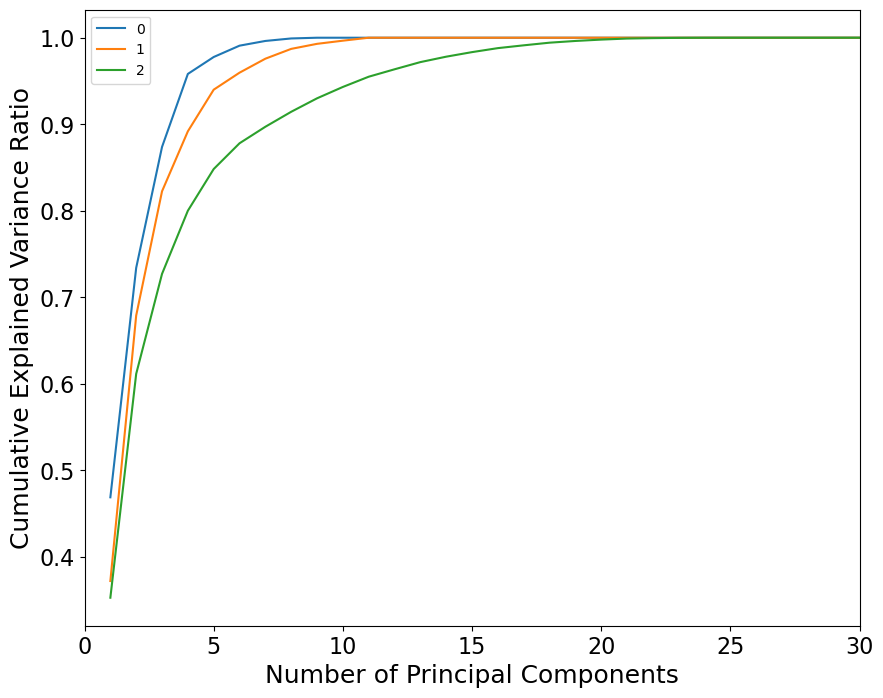

In [90]:
## make the explained variance curve
## make the explained variance curve
plt.figure(figsize=(10,8))

for i in range(3):

    pca = PCA()

    pca.fit(df_FADM[clusters==i])


    plt.plot(range(1, len(pca.explained_variance_ratio_)+1),
                np.cumsum(pca.explained_variance_ratio_),label=i)

    plt.ylabel("Cumulative Explained Variance Ratio", fontsize=18)
    plt.xlabel("Number of Principal Components", fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    plt.xlim(0,30)

plt.legend()

In [59]:
len(df_FADM)

2095